In [1]:
import numpy as np
import torch
import requests
import cv2
import threading
import os
import json
from tqdm import tqdm
from torch.nn.functional import pad, interpolate
import matplotlib.pyplot as plt

debug = False

# Load and Reformat Data

In [2]:
all_segs = torch.tensor(np.load("all_segs.npy"))    # (B, N_segs, N_interp, 2)
all_routes = torch.tensor(np.load("all_routes.npy"))    # (B, N_trajs, L_route, N_interp, 2)
all_trajs = torch.tensor(np.load("all_trajs.npy"))  
graph_bboxes = np.load("graph_bboxes.npy")

data_count = all_segs.shape[0]
N_trajs = all_routes.shape[1]
N_segs = all_segs.shape[1]
max_route_len = all_routes.shape[2]
max_traj_len = all_trajs.shape[2]

print(f"{data_count=}\n{N_trajs=}\n{max_route_len=}\n{max_traj_len=}")

traj_lens = torch.sum(torch.all(all_trajs != 0, dim=-1), dim=-1)
route_lens = torch.sum(torch.all(all_routes.flatten(-2, -1) != 0, dim=-1), dim=-1)
seg_nums = torch.sum(torch.all(all_segs.flatten(-2, -1) != 0, dim=-1), dim=-1)  # (B,)

print(traj_lens.shape)
print(route_lens.shape)
print(seg_nums.shape)

if not debug:
    all_mean = torch.zeros(data_count, 1, 1, 2, dtype=torch.float32)
    all_std = torch.zeros(data_count, 1, 1, 2, dtype=torch.float32)

    for b in tqdm(range(data_count)):
        # (N_points, 2)
        traj_points = torch.cat([all_trajs[b, i, :traj_lens[b, i]] for i in range(N_trajs)], dim=0)
        mean_point = traj_points.mean(dim=0).view(1, 1, 2)
        std_point = traj_points.std(dim=0).view(1, 1, 2)
        all_mean[b] = mean_point
        all_std[b] = std_point
        for traj_i in range(N_trajs):
            valid_len = traj_lens[b, traj_i]
            all_trajs[b, traj_i, :valid_len] = (all_trajs[b, traj_i, :valid_len] - mean_point) / std_point
            
            valid_len = route_lens[b, traj_i]
            all_routes[b, traj_i, :valid_len] = (all_routes[b, traj_i, :valid_len] - mean_point.unsqueeze(0)) / std_point.unsqueeze(0)
            for seg_i in range(valid_len):
                # Ensure the unique direction of segments
                if all_routes[b, traj_i, seg_i, 0, 0] > all_routes[b, traj_i, seg_i, -1, 0]:
                    all_routes[b, traj_i, seg_i] = all_routes[b, traj_i, seg_i].flip(0)

        valid_len = seg_nums[b]
        all_segs[b, :valid_len] = (all_segs[b, :valid_len] - mean_point) / std_point
        for seg_i in range(valid_len):
            if all_segs[b, seg_i, 0, 0] > all_segs[b, seg_i, -1, 0]:
                all_segs[b, seg_i] = all_segs[b, seg_i].flip(0)

data_count=1000
N_trajs=48
max_route_len=8
max_traj_len=16
torch.Size([1000, 48])
torch.Size([1000, 48])
torch.Size([1000])


100%|██████████| 1000/1000 [00:03<00:00, 260.27it/s]


# Prepare Image download

In [3]:
# This code block is from https://github.com/andolg/satellite-imagery-downloader
cache_dict = dict()
def get_downloader_with_cache(url, headers, channels, zoom):
    def download_tile(tile_x, tile_y):
        global cache_dict
        key = (tile_x, tile_y)
        if key in cache_dict:
            return cache_dict[key]
        else:
            response = requests.get(url.format(x=tile_x, y=tile_y, z=zoom), headers=headers)
            arr = np.asarray(bytearray(response.content), dtype=np.uint8)
        
            if channels == 3:
                result = cv2.imdecode(arr, 1)
            else:
                result = cv2.imdecode(arr, -1)
            cache_dict[(tile_x, tile_y)] = result
            return result
            
    return download_tile

# Mercator projection
# https://developers.google.com/maps/documentation/javascript/examples/map-coordinates
def project_with_scale(lat, lon, scale):
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    x = scale * (0.5 + lon / 360)
    y = scale * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    return x, y

def download_image(lat1: float, lon1: float, lat2: float, lon2: float,
                   zoom: int, url: str, headers: dict, tile_size: int = 256, channels: int = 3) -> np.ndarray:
    """
    Downloads a map region. Returns an image stored as a `numpy.ndarray` in BGR or BGRA, depending on the number
    of `channels`.

    Parameters
    ----------
    `(lat1, lon1)` - Coordinates (decimal degrees) of the top-left corner of a rectangular area

    `(lat2, lon2)` - Coordinates (decimal degrees) of the bottom-right corner of a rectangular area

    `zoom` - Zoom level

    `url` - Tile URL with {x}, {y} and {z} in place of its coordinate and zoom values

    `headers` - Dictionary of HTTP headers

    `tile_size` - Tile size in pixels

    `channels` - Number of channels in the output image. Also affects how the tiles are converted into numpy arrays.
    """

    scale = 1 << zoom

    # Find the pixel coordinates and tile coordinates of the corners
    tl_proj_x, tl_proj_y = project_with_scale(lat1, lon1, scale)
    br_proj_x, br_proj_y = project_with_scale(lat2, lon2, scale)

    tl_pixel_x = int(tl_proj_x * tile_size)
    tl_pixel_y = int(tl_proj_y * tile_size)
    br_pixel_x = int(br_proj_x * tile_size)
    br_pixel_y = int(br_proj_y * tile_size)

    tl_tile_x = int(tl_proj_x)
    tl_tile_y = int(tl_proj_y)
    br_tile_x = int(br_proj_x)
    br_tile_y = int(br_proj_y)

    img_w = abs(tl_pixel_x - br_pixel_x)
    img_h = br_pixel_y - tl_pixel_y
    img = np.zeros((img_h, img_w, channels), np.uint8)

    downloader = get_downloader_with_cache(url, headers, channels, zoom)

    def build_row(tile_y):
        for tile_x in range(tl_tile_x, br_tile_x + 1):
            tile = downloader(tile_x, tile_y)

            if tile is not None:
                # Find the pixel coordinates of the new tile relative to the image

                tl_rel_x = tile_x * tile_size - tl_pixel_x
                tl_rel_y = tile_y * tile_size - tl_pixel_y
                br_rel_x = tl_rel_x + tile_size
                br_rel_y = tl_rel_y + tile_size

                # Define where the tile will be placed on the image
                img_x_l = max(0, tl_rel_x)
                img_x_r = min(img_w + 1, br_rel_x)
                img_y_l = max(0, tl_rel_y)
                img_y_r = min(img_h + 1, br_rel_y)

                # Define how border tiles will be cropped
                cr_x_l = max(0, -tl_rel_x)
                cr_x_r = tile_size + min(0, img_w - br_rel_x)
                cr_y_l = max(0, -tl_rel_y)
                cr_y_r = tile_size + min(0, img_h - br_rel_y)

                img[img_y_l:img_y_r, img_x_l:img_x_r] = tile[cr_y_l:cr_y_r, cr_x_l:cr_x_r]

    
    for tile_y in range(tl_tile_y, br_tile_y + 1):
        build_row(tile_y)
    return img

prefs = {
    'url': 'https://mt.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    'tile_size': 256,
    'channels': 3,
    'dir': 'images',
    'headers': {
        'cache-control': 'max-age=0',
        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="99", "Google Chrome";v="99"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'document',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'none',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.82 Safari/537.36'
    },
    'tl': '',
    'br': '',
    'zoom': ''
}

# with open(prefs_path, 'w', encoding='utf-8') as f:
#     json.dump(default_prefs, f, indent=2, ensure_ascii=False)
# 
# with open('preferences.json', 'r', encoding='utf-8') as f:
#     prefs = json.loads(f.read())

# zoom_levels = [
#     78271.52, 39135.76, 19567.88, 9783.94, 4891.97, 2445.98, 1222.99, 611.50, 305.75, 152.87, # 1 - 10
#     76.44, 38.22, 19.11, 9.55, 4.78, 2.39, 1.19, 0.60, 0.30 # 11 - 19
# ]

# Download Images

In [4]:
n_threads = 4
images = [[] for _ in range(n_threads)]
progress = [0 for _ in range(n_threads)]
total = 0

def download_images(task_i, start, stop):
    global progress
    global total
    global images
    print(task_i, start, stop)
    for b in range(start, stop):
        min_lat, max_lat, min_lon, max_lon = graph_bboxes[b]
        top, left, bottom, right = max_lat, min_lon, min_lat, max_lon
        img = download_image(top, left, bottom, right, 17, prefs['url'], prefs['headers'], int(prefs['tile_size']), int(prefs['channels']))
        images[task_i].append(torch.tensor(img, dtype=torch.float32).flip(0) / 255)
        progress[task_i] += 1
        total += 1

threads = []

base_size = data_count // n_threads
start = 0
for i in range(n_threads):
    if i == n_threads - 1:
        end = data_count
    else:
        end = start + base_size
    thread = threading.Thread(target=download_images, args=[i, start, end])
    thread.start()
    threads.append(thread)
    start = end
    threading.Event().wait(0.1)

print("Downloading images")

while total < data_count:
    print(f"\r{total:05d}/{data_count}\t" + " ".join([f"{each:04d}" for each in progress]), end="")
    threading.Event().wait(0.1)

for thread in threads:
    thread.join()
    
images = sum(images, [])

0 0 250
1 250 500
2 500 750
3 750 1000
00998/1000	0248 0250 0250 0250

# Generate Heatmaps

In [5]:
h, w = 256, 256

heatmaps = []
for b in tqdm(range(data_count), desc="Generating heatmaps"):
    trajs = all_trajs[b]
    traj_len = traj_lens[b]
    if torch.all(traj_len != 0):
        points = torch.cat([trajs[i, :traj_len[i]] for i in range(N_trajs)], dim=0)
        min_point = torch.min(points, dim=0, keepdim=True).values
        max_point = torch.max(points, dim=0, keepdim=True).values
        point_range = max_point - min_point
    
        norm_points = (points - min_point) / point_range
    
        x_ids = (norm_points[:, 0] * (w - 1)).long()
        y_ids = (norm_points[:, 1] * (h - 1)).long()
        heatmap_flat = torch.zeros(h * w, dtype=torch.float32)
        flat_indices = y_ids * w + x_ids
        heatmap_flat.scatter_add_(0, flat_indices, torch.ones_like(flat_indices, dtype=torch.float32))
        heatmaps.append(heatmap_flat.view(h, w))
    else:
        heatmaps.append(torch.zeros(h, w, dtype=torch.float32))

Generating heatmaps: 100%|██████████| 1000/1000 [00:00<00:00, 4960.95it/s]


In [6]:
# plot images
if debug:
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(3):
        for j in range(3):
            b = i * 3 + j
            img_with_heat = images[b].clone()
            img_with_heat[..., 0] += heatmaps[b]
            min_lat, max_lat, min_lon, max_lon = graph_bboxes[b]
            axes[i, j].imshow(img_with_heat, origin="lower", extent=(min_lon, max_lon, min_lat, max_lat))
            axes[i, j].axis("equal")
            for k in range(N_trajs):
                for route in all_routes[b, k]:
                    if not torch.all(route == 0):
                        axes[i, j].plot(route[:, 0], route[:, 1], color="red", alpha=0.5)
                traj = all_trajs[b, k]
                non_zeros = torch.all(traj != 0, dim=1)
                axes[i, j].plot(traj[non_zeros, 0], traj[non_zeros, 1], color="blue", alpha=0.2)

    plt.show()


# Resize and Save

In [7]:
max_h = 0
max_w = 0
for b in range(data_count):
    h, w = images[b].shape[:2]
    max_h = max(max_h, h)
    max_w = max(max_w, w)
print(max_h, max_w)

833 672


In [8]:
resize = max(max_h, max_w)
print(resize)

target_size = 256

833


In [9]:
for b in tqdm(range(data_count)):
    h, w = images[b].shape[:2]
    # pad_h = pad_size - h
    # pad_w = pad_size - w
    # images[b] = pad(images[b].permute(2, 0, 1), (0, pad_h, 0, pad_w))
    # heatmaps[b] = pad(heatmaps[b].unsqueeze(0), (0, pad_h, 0, pad_w))

    images[b] = interpolate(images[b].permute(2, 0, 1).unsqueeze(0), (target_size, target_size), mode="bilinear", align_corners=False).squeeze(0)
    heatmaps[b] = interpolate(heatmaps[b].unsqueeze(0).unsqueeze(0), (target_size, target_size), mode="bilinear", align_corners=False).squeeze(0)
    
torch.save({
    "segs": all_segs.to(torch.float32),
    "routes": all_routes,
    "trajs": all_trajs,
    "point_mean": all_mean,
    "point_std": all_std,
    "bboxes": torch.tensor(graph_bboxes).to(torch.float32),
    "traj_lens": traj_lens,
    "route_lens": route_lens,
    "seg_nums": seg_nums,
    "images": torch.stack(images, dim=0),
    "heatmaps": torch.stack(heatmaps, dim=0)
}, "dataset.pt")

100%|██████████| 1000/1000 [00:00<00:00, 1142.10it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


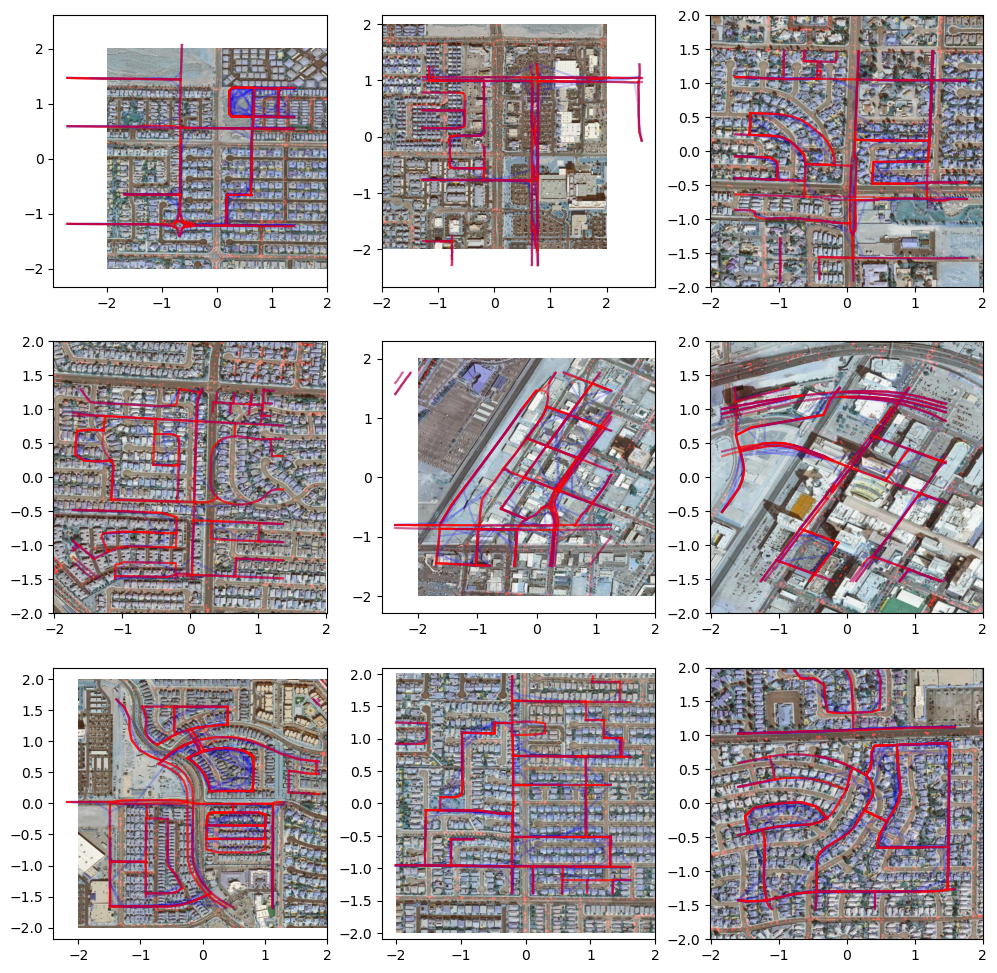

In [10]:
# plot images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        b = i * 3 + j
        img_with_heat = images[b].permute(1, 2, 0).clone()
        img_with_heat[..., 0] += heatmaps[b][0]
        min_lat, max_lat, min_lon, max_lon = graph_bboxes[b]
        axes[i, j].imshow(img_with_heat, origin="lower", extent=(-2, 2, -2, 2))
        axes[i, j].axis("equal")
        for k in range(N_trajs):
            route = all_routes[b, k]
            for seg_i in range(len(route)):
                axes[i, j].plot(route[seg_i, :, 0], route[seg_i, :, 1], color="red", alpha=0.5)
            traj = all_trajs[b, k]
            non_zeros = torch.all(traj != 0, dim=1)
            axes[i, j].plot(traj[non_zeros, 0], traj[non_zeros, 1], color="blue", alpha=0.2)

plt.show()